# Noise2Self for Super-Resolution Microscopy

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks, applied to PALM super-resolution microscopy data.

The characteristic feature of PALM is sparse Poisson sampling from a continuous structure.

The independence structure we exploit is the independence between individual fluorescence events.

Here, we show this on real experimental data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor, nn

# Model

In [5]:
device = 'cpu'

In [6]:
from util import getbestgpu
#device = getbestgpu()

For our model, we use a short UNet with two levels of up- and down- sampling

In [7]:
from models.babyunet import BabyUnet
from models.unet import Unet
model = BabyUnet()

# Training

In [8]:
from torch.nn import MSELoss, PoissonNLLLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
mse = MSELoss()

loss_function = PoissonNLLLoss()

In [9]:
from models.babyunet import BabyUnet

model = BabyUnet(width = 32)

In [10]:
optimizer = Adam(model.parameters(), lr=0.001)

# Data

In [11]:
from loader.plot_hist import plotHist
from loader.smlm_file import import_smlm

manifest, files = import_smlm('data/palm/s4b-c1-7pos-30k-20ms_1_MMStack_Pos0_1_min.smlm')
table = files[0]['data']['tableDict']

/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


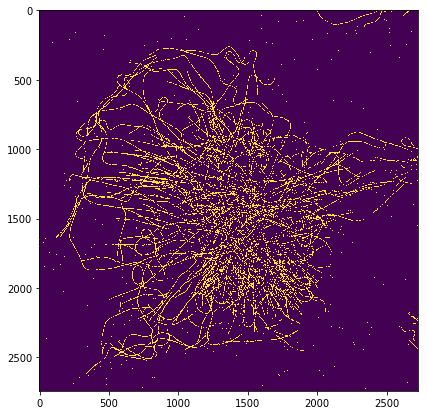

In [12]:
h = plotHist(table, frame_range=(300,100000), value_range=(0,1))
plt.figure(figsize=(7, 7))
plt.imshow(np.clip(h, 0, 2))

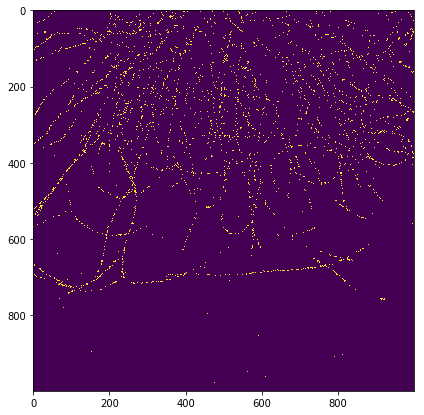

In [13]:
clean = plotHist(table, frame_range=(300,1500), 
                 value_range=(0,1),
                 xy_range=[(1000*20, 2000*20),(1700*20, 2700*20)])
plt.figure(figsize=(7, 7))
plt.imshow(clean.astype(np.uint8))

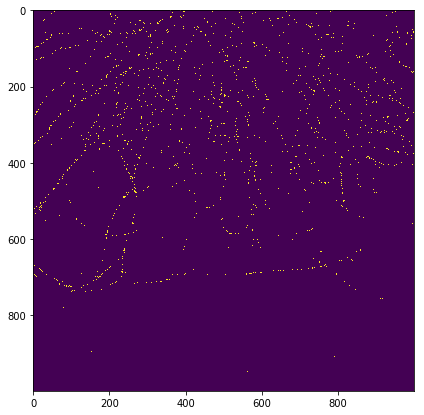

In [14]:
clean = plotHist(table, frame_range=(300,800), 
                 value_range=(0,1),
                 xy_range=[(1000*20, 2000*20),(1700*20, 2700*20)])
plt.figure(figsize=(7, 7))
plt.imshow(clean.astype(np.uint8))

In [253]:
from loader.smlm_datasets import get_localization_source

#file_type = 'csv'
#data_dir = '/Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/csv-files/test'
file_type = 'smlm'
data_dir = '/Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/smlm-files/train'

source_train = get_localization_source(data_dir, file_type=file_type)

Found 7 samples in /Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/smlm-files/train.


In [257]:
for input_arr, target_arr, path, _, _ in source_train:
    print(input_arr.shape, target_arr.shape, path)

(2560, 2560, 1) (2560, 2560, 1) /Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/smlm-files/train/Ctrl-lowDens_pos10.smlm
(2560, 2560, 1) (2560, 2560, 1) /Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/smlm-files/train/Ctrl-lowDens_pos11.smlm
(2560, 2560, 1) (2560, 2560, 1) /Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/smlm-files/train/Ctrl-lowDens_pos4.smlm
(2560, 2560, 1) (2560, 2560, 1) /Users/weiouyang/Dropbox (Imod Pasteur)/ANNA-PALM-paper/ANNAPALM-SOFTWARE/training_data/microtubules-data-annapalm/smlm-files/train/Ctrl-lowDens_pos5.smlm


KeyboardInterrupt: 

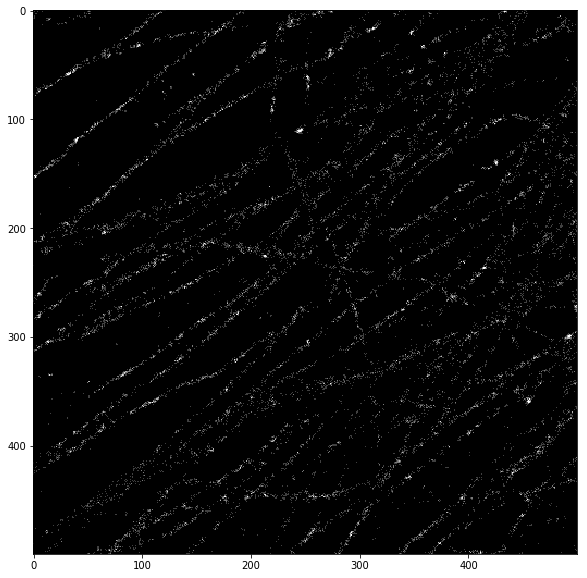

In [252]:
a, b, c, d, e = source_train
plt.figure(figsize=(10,10))
plt.imshow(a[500:1000,500:1000,0], cmap = 'Greys_r')

In [123]:
histin = Tensor(histin[:, :, 0]).unsqueeze(0).unsqueeze(0)
histout = Tensor(histout[:, :, 0]).unsqueeze(0).unsqueeze(0)

NameError: name 'histin' is not defined

In [22]:
noisy1 = plotHist(files[0]['data']['tableDict'], frame_range=(300,2000), 
                 value_range=(0,3))
noisy2 = plotHist(files[0]['data']['tableDict'], frame_range=(2000,3700), 
                 value_range=(0,3))
clean = plotHist(files[0]['data']['tableDict'], frame_range=(1300,100000), 
                 value_range=(0,20))

clean = clean/clean.mean() * noisy2.mean()

In [23]:
noisy1 = noisy1[:,:-1]
noisy2 = noisy2[:,:-1]
clean = clean[:,:-1]

In [24]:
center = noisy1.shape[0]//2
noisy1 = noisy1[(center - 500):(center + 500), (center - 500):(center + 500)]
noisy2 = noisy2[(center - 500):(center + 500), (center - 500):(center + 500)]
clean = clean[(center - 500):(center + 500), (center - 500):(center + 500)]

In [25]:
noisy1.shape

(1000, 1000)

In [26]:
noisy1 = Tensor(noisy1).unsqueeze(0).unsqueeze(0)
noisy2 = Tensor(noisy2).unsqueeze(0).unsqueeze(0)
clean = Tensor(clean).unsqueeze(0).unsqueeze(0)

In [27]:
noisy1.size()

torch.Size([1, 1, 1000, 1000])

In [20]:
from models.babyunet import BabyUnet

model = BabyUnet(width = 32)
#model = DnCNN(1, num_of_layers=12)

mse = MSELoss()
loss_function = PoissonNLLLoss()

In [21]:
import torch
torch.__version__

'1.0.1.post2'

In [22]:
optimizer = Adam(model.parameters(), lr=0.0001)

In [23]:
model = model.to(device)
model.train()

num_epochs = 60
for epoch in range(num_epochs):
    net_input = noisy1.to(device)
    net_output = model(net_input)

    loss = loss_function(net_output, noisy2.to(device))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % 2 == 0:
        test_loss = mse(model(net_input).exp(), clean.to(device)).item()
        print("Loss (", epoch, "): ", np.round(loss.item(), 3), np.round(test_loss, 5))

/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss ( 0 ):  0.701 0.34254
Loss ( 2 ):  0.573 0.23883
Loss ( 4 ):  0.506 0.19219
Loss ( 6 ):  0.47 0.17021
Loss ( 8 ):  0.444 0.14775
Loss ( 10 ):  0.42 0.12795
Loss ( 12 ):  0.402 0.11464
Loss ( 14 ):  0.389 0.10562
Loss ( 16 ):  0.377 0.09811
Loss ( 18 ):  0.367 0.09206
Loss ( 20 ):  0.358 0.08701
Loss ( 22 ):  0.35 0.08246
Loss ( 24 ):  0.343 0.07845
Loss ( 26 ):  0.335 0.07489
Loss ( 28 ):  0.328 0.07176
Loss ( 30 ):  0.321 0.0691
Loss ( 32 ):  0.315 0.06692
Loss ( 34 ):  0.31 0.06497
Loss ( 36 ):  0.305 0.06309


KeyboardInterrupt: 

The log-likelihood provided by the 'clean' data itself is:

In [24]:
loss_function((clean + 1e-5).log().to(device), noisy2.to(device)).item()

0.4635394513607025

Since this is actually worse than the loglikelihood we produce, there must be some bias.

In [25]:
prediction = model(noisy1.to(device)).exp().detach().cpu()[0,0].numpy()
prediction = np.clip(prediction, 0, 1)

/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [26]:
clean.max()

tensor(2.0564)

/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


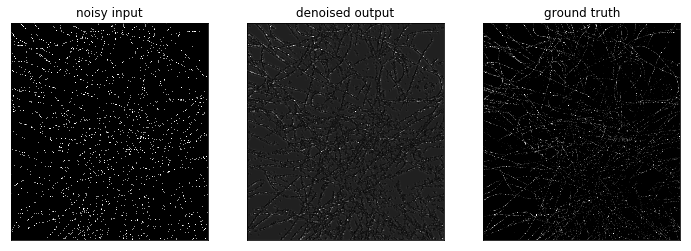

In [27]:
plot_tensors([noisy1.clamp(0, clean.max()), model(noisy1.to(device)).exp().clamp(0, clean.max()), clean],
            ["noisy input", "denoised output", "ground truth"])

In [101]:
inset = lambda x: x[0:600, 200:800]
degpu = lambda x: x.detach().cpu()[0,0].numpy()

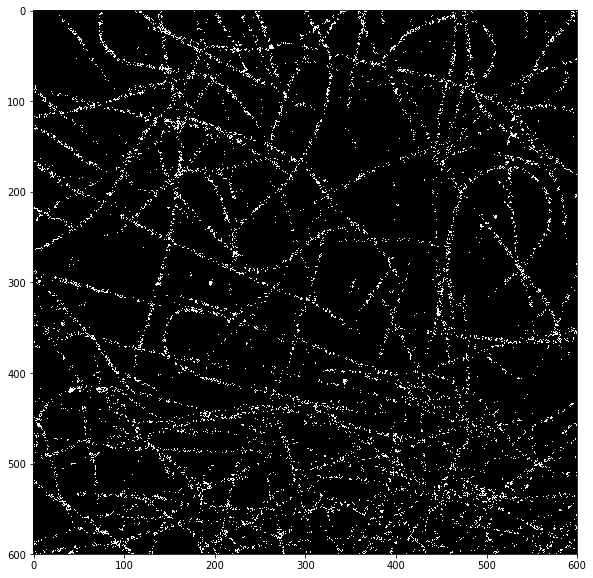

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(inset(degpu(noisy1)).clip(0, 0.1), cmap = 'Greys_r')

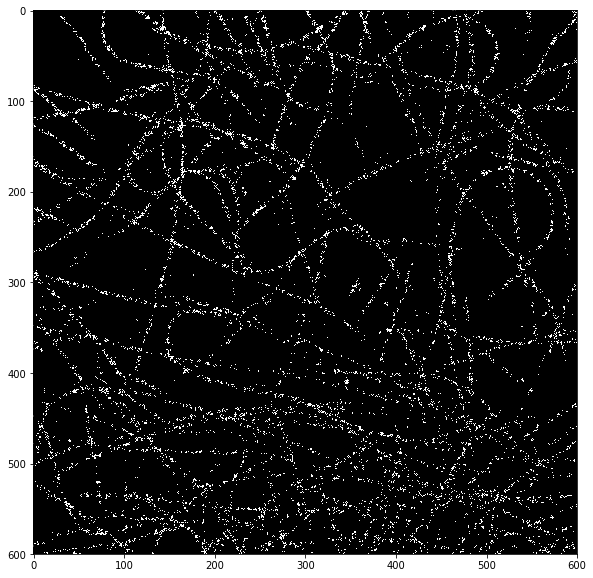

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(inset(degpu(noisy2)).clip(0, 0.1), cmap = 'Greys_r')

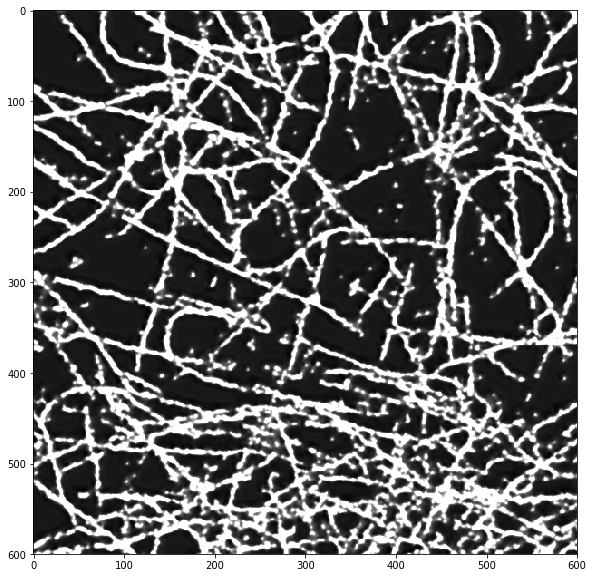

In [104]:
plt.figure(figsize=(10,10))
plt.imshow(inset(prediction).clip(0,0.1), cmap = 'Greys_r')

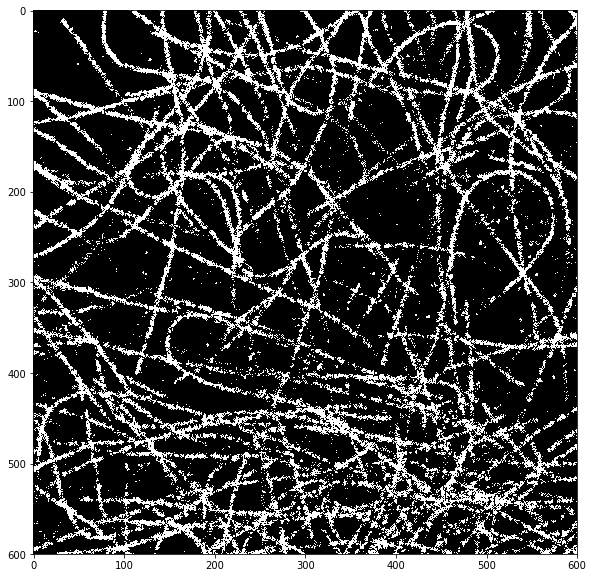

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(inset(degpu(clean)).clip(0, 0.1), cmap = 'Greys_r')